In [1]:
from configparser import ConfigParser
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree, svm
from sklearn.tree import DecisionTreeClassifier,export_text
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix, classification_report
from sklearn.datasets import load_iris
from collections import Counter 
import datetime
import pickle
import time
import os
from random import randint

/Applications/anaconda3/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
#Sourced from https://www.postgresqltutorial.com/postgresql-python/connect/
def config(filename='psql_sample.ini', section='postgresql'):
    parser = ConfigParser()
    # read config file
    parser.read(filename) 
 
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db

In [3]:
cfg = config()

In [4]:
#Establish the connection and create a cursor to the database
try:
    print("Here's an attempt to connect to the database")
    conn = psycopg2.connect(
        host="www.eecs.uottawa.ca",
        database="group_22",
        user="yzhao156",
        password="#####Uozone#####",
        port=15432
    )
    cursor = conn.cursor()
    print("Look's like it was a success")
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Here's an attempt to connect to the database
Look's like it was a success


In [5]:
try:
    #Lets get our data 
    cursor.execute(
    """
SELECT D.month as month,  S.title as special_measure, 
    P.Age_Group as Age_Group, P.client_gender as gender, 
    M.parks_percent_change_from_baseline as a,
    M.workplaces_percent_change_from_baseline as b,
    M.residential_percent_change_from_baseline as c,
    M.transit_stations_percent_change_from_baseline as d,
    F.fatal as fatal
FROM covid19_tracking_fact_table F, 
    date_dimension D, 
    mobility_dimension M,
    special_measures_dimension S,
    patient_dimension P
WHERE F.reported_date_key = D.surrogate_key AND
    F.special_measure_key = S.surrogate_key AND
    F.mobility_key = M.surrogate_key AND
    F.patient_key = P.surrogate_key 
ORDER BY D.date
    """ )
    #Get the complete result set. It will be a list of tuples where each tuple is a row from the result set
    result_list = cursor.fetchall()
        
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

In [6]:
cursor.close()
conn.close()

In [7]:
data = pd.DataFrame(result_list,columns=["month", "special_measure",
                "Age_Group", "gender", "park", "workplace", "residential","transit","fatal"])

In [8]:
data.head()

,month,special_measure,Age_Group,gender,park,workplace,residential,transit,fatal
0,11,Restrict,20s,MALE,-26.0,-11.0,6.0,-59.0,0
1,11,Restrict,20s,MALE,-26.0,-11.0,6.0,-59.0,0
2,11,Restrict,40s,FEMALE,-26.0,-11.0,6.0,-59.0,0
3,11,Restrict,50s,MALE,-26.0,-11.0,6.0,-59.0,0
4,11,Restrict,20s,FEMALE,-26.0,-11.0,6.0,-59.0,0


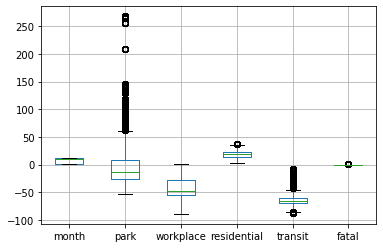

In [9]:
data.boxplot(column=["month", "park", "workplace", "residential","transit", "fatal"])

(array([3.14164004, 0.        , 0.        , 0.        , 0.        ,
        3.83386581, 0.        , 0.        , 0.        , 0.        ,
        3.52502662, 0.        , 0.        , 0.        , 0.        ,
        2.97124601, 0.        , 0.        , 0.        , 0.        ,
        3.83386581, 0.        , 0.        , 0.        , 0.        ,
        3.68477103, 0.        , 0.        , 0.        , 0.        ,
        4.69648562, 0.        , 0.        , 0.        , 0.        ,
        8.10436635, 0.        , 0.        , 0.        , 6.20873269]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <a list of 1 Patch objects>)

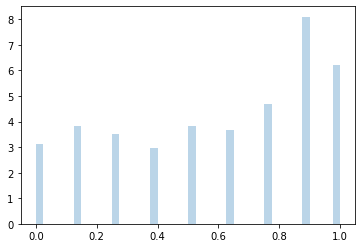

In [57]:
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40)
plt.hist(data['Age_Group'], **kwargs)

# A.2

In [11]:
data.isna().sum()

month              0
special_measure    0
Age_Group          0
gender             0
park               0
workplace          0
residential        0
transit            0
fatal              0
dtype: int64

In [12]:
data = data[data['Age_Group']!="UNKNOWN"]

In [13]:
data['Age_Group'].drop_duplicates()

0      20s
2      40s
3      50s
5      70s
9      <20
10     30s
12     60s
19     80s
542    90+
Name: Age_Group, dtype: object

In [14]:
mapping_age = {
    '<20':0,
    '20s':1,
    '30s':2,
    '40s':3,
    '50s':4,
    '60s':5,
    '70s':6,
    '80s':7,
    '90+':8
}
data['Age_Group'] = data['Age_Group'].map(lambda x : mapping_age[x])
    

In [15]:
mapping_month = {
    11:1,
    12:2,
    1:3,
    2:4
}
data['month'] = data['month'].map(lambda x : mapping_month[x])

In [16]:
mapping_gender = {
    'MALE':0,
    'FEMALE':1,
    'UNSPECIFIED':2,
    'GENDER DIVERSE':3
}
data['gender'] = data['gender'].map(lambda x : mapping_gender[x])


In [17]:
print(data[data['gender']==3]['gender'].count())
print(data[data['gender']==2]['gender'].count())
print(data[data['gender']==1]['gender'].count())
data = data[data['gender']<2]

12
626
73283


In [18]:
one_hot = pd.get_dummies(data.special_measure, prefix='special_measure')
one_hot.shape

(147254, 5)

In [19]:
data.shape

(147254, 9)

In [20]:
data = pd.concat([data,one_hot],axis=1)
data = data.drop(columns=['special_measure'])
data

,month,Age_Group,gender,park,workplace,residential,transit,fatal,special_measure_Control,special_measure_Lockdown,special_measure_Prevent,special_measure_Protect,special_measure_Restrict
0,1,1,0,-26.0,-11.0,6.0,-59.0,0,0,0,0,0,1
1,1,1,0,-26.0,-11.0,6.0,-59.0,0,0,0,0,0,1
2,1,3,1,-26.0,-11.0,6.0,-59.0,0,0,0,0,0,1
3,1,4,0,-26.0,-11.0,6.0,-59.0,0,0,0,0,0,1
4,1,1,1,-26.0,-11.0,6.0,-59.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147899,4,0,1,29.0,-13.0,10.0,-55.0,0,1,0,0,0,0
147900,4,5,0,29.0,-13.0,10.0,-55.0,0,1,0,0,0,0
147901,4,1,0,29.0,-13.0,10.0,-55.0,0,1,0,0,0,0
147902,4,0,1,28.0,-3.0,6.0,-58.0,0,0,0,0,1,0


### normalisation

In [21]:
#normalize mobility
l = ['month','park','Age_Group', 'workplace','residential','transit']
for i in l:
    data[i] = (data[i]-data[i].min())/(data[i].max()-data[i].min())

In [22]:
data

,month,Age_Group,gender,park,workplace,residential,transit,fatal,special_measure_Control,special_measure_Lockdown,special_measure_Prevent,special_measure_Protect,special_measure_Restrict
0,0.0,0.125,0,0.084112,0.857143,0.088235,0.3625,0,0,0,0,0,1
1,0.0,0.125,0,0.084112,0.857143,0.088235,0.3625,0,0,0,0,0,1
2,0.0,0.375,1,0.084112,0.857143,0.088235,0.3625,0,0,0,0,0,1
3,0.0,0.500,0,0.084112,0.857143,0.088235,0.3625,0,0,0,0,0,1
4,0.0,0.125,1,0.084112,0.857143,0.088235,0.3625,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147899,1.0,0.000,1,0.255452,0.835165,0.205882,0.4125,0,1,0,0,0,0
147900,1.0,0.625,0,0.255452,0.835165,0.205882,0.4125,0,1,0,0,0,0
147901,1.0,0.125,0,0.255452,0.835165,0.205882,0.4125,0,1,0,0,0,0
147902,1.0,0.000,1,0.252336,0.945055,0.088235,0.3750,0,0,0,0,1,0


In [23]:
if not os.path.exists('saves'):
    os.makedirs('saves')
pickle.dump( data, open( "./saves/prereocessed_data.p", "wb" ) )

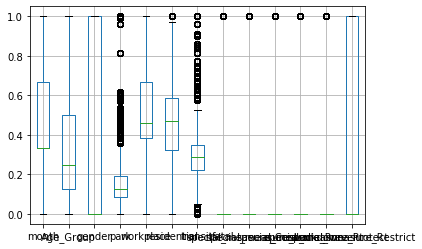

In [24]:
# data = pickle.load( open( "./saves/prereocessed_data.p", "rb" ) )
data.boxplot(column=data.columns.values.tolist())

### undersampling

In [25]:
shuffle_unresolved = shuffle(data[data['fatal']==0])
shuffle_resolved = shuffle(data[data['fatal']==1])
shuffle_resolved = shuffle_resolved[:len(shuffle_unresolved)]
undersampled_data = shuffle_resolved.append(shuffle_unresolved)
undersampled_data = shuffle(undersampled_data)

In [26]:
if not os.path.exists('saves'):
    os.makedirs('saves')
pickle.dump( undersampled_data, open( "./saves/undersampled_data.p", "wb" ) )

In [27]:
undersampled_data.describe()

,month,Age_Group,gender,park,workplace,residential,transit,fatal,special_measure_Control,special_measure_Lockdown,special_measure_Prevent,special_measure_Protect,special_measure_Restrict
count,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000,147254.000000
mean,0.479213,0.331319,0.497664,0.154145,0.510049,0.454647,0.297839,0.012753,0.185890,0.217977,0.223213,0.122333,0.250587
std,0.326122,0.252127,0.499996,0.108316,0.194833,0.179794,0.111775,0.112209,0.389019,0.412873,0.416401,0.327671,0.433353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.125000,0.000000,0.084112,0.384615,0.323529,0.225000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.333333,0.250000,0.000000,0.124611,0.461538,0.470588,0.287500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,0.500000,1.000000,0.193146,0.670330,0.588235,0.350000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


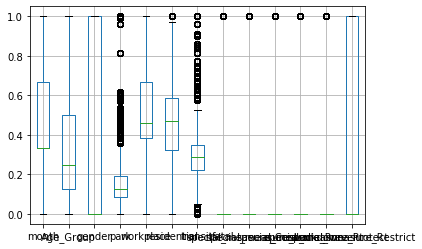

In [28]:
undersampled_data.boxplot(column=undersampled_data.columns.values.tolist())

# Part B

## Decision Tree

In [29]:
# split the train and test data
data = pickle.load(open("./saves/undersampled_data.p", "rb" ))

res=data[data['fatal']==1]
rest=data[data['fatal']==0]
tmp=randint(0,len(rest)-len(res))
tmp=rest[tmp:tmp+len(res)]
res=res.append(tmp)
data=res

column_list = data.columns.values.tolist()
column_list.remove('fatal')

X = data[column_list]
y = data['fatal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
data

,month,Age_Group,gender,park,workplace,residential,transit,fatal,special_measure_Control,special_measure_Lockdown,special_measure_Prevent,special_measure_Protect,special_measure_Restrict
27365,0.000000,0.875,1,0.526480,0.923077,0.176471,0.8625,1,0,1,0,0,0
104299,0.666667,1.000,1,0.046729,0.428571,0.617647,0.2000,1,1,0,0,0,0
14764,0.000000,1.000,1,0.096573,0.538462,0.411765,0.3000,1,0,0,0,1,0
55102,0.333333,0.875,1,0.118380,0.527473,0.441176,0.3250,1,0,1,0,0,0
66617,0.333333,0.875,0,0.109034,0.494505,0.382353,0.2375,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,0.000000,0.250,1,0.040498,0.824176,0.147059,0.2875,0,0,0,0,1,0
15923,0.000000,0.500,1,0.140187,0.538462,0.382353,0.3375,0,0,0,0,1,0
58002,0.333333,0.500,0,0.149533,0.758242,0.176471,0.4500,0,0,0,0,0,1
58021,0.333333,0.875,0,0.149533,0.758242,0.176471,0.4500,0,0,0,0,0,1


In [30]:
#Train the data
#decision_tree = DecisionTreeClassifier(criterion='entropy',
            #max_features=None,max_leaf_nodes=,max_leaf_nodes=16,
            #random_state=0,)
decision_tree = DecisionTreeClassifier(class_weight='balanced',criterion='entropy',min_impurity_decrease=1e-07,max_depth=5,max_leaf_nodes=16,random_state=0,splitter='best')
start = time.time()
decision_tree = decision_tree.fit(X_train, y_train)
time_took = time.time()-start
#show the decision condiction and the structure of the tree
final_condiction= export_text(decision_tree, feature_names=column_list)
print(final_condiction)
#tree.plot_tree(decision_tree) 

|--- Age_Group <= 0.69
|   |--- Age_Group <= 0.44
|   |   |--- Age_Group <= 0.19
|   |   |   |--- class: 0
|   |   |--- Age_Group >  0.19
|   |   |   |--- transit <= 0.23
|   |   |   |   |--- class: 0
|   |   |   |--- transit >  0.23
|   |   |   |   |--- workplace <= 0.73
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- workplace >  0.73
|   |   |   |   |   |--- class: 0
|   |--- Age_Group >  0.44
|   |   |--- Age_Group <= 0.56
|   |   |   |--- gender <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- gender >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Age_Group >  0.56
|   |   |   |--- special_measure_Control <= 0.50
|   |   |   |   |--- special_measure_Lockdown <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- special_measure_Lockdown >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- special_measure_Control >  0.50
|   |   |   |   |--- transit <= 0.29
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- transit >  0.29
|   |   |   |   |   |--- 

[Text(162.16875000000002, 199.32, 'X[1] <= 0.688\nentropy = 1.0\nsamples = 2817\nvalue = [1408.5, 1408.5]'),
 Text(80.2125, 163.07999999999998, 'X[1] <= 0.438\nentropy = 0.552\nsamples = 1487\nvalue = [1285.85, 189.081]'),
 Text(27.900000000000002, 126.83999999999999, 'X[1] <= 0.188\nentropy = 0.136\nsamples = 967\nvalue = [938.67, 18.2]'),
 Text(13.950000000000001, 90.6, 'entropy = 0.021\nsamples = 505\nvalue = [498.514, 1.011]'),
 Text(41.85, 90.6, 'X[6] <= 0.231\nentropy = 0.231\nsamples = 462\nvalue = [440.156, 17.189]'),
 Text(27.900000000000002, 54.359999999999985, 'entropy = 0.0\nsamples = 111\nvalue = [109.792, 0.0]'),
 Text(55.800000000000004, 54.359999999999985, 'X[4] <= 0.731\nentropy = 0.284\nsamples = 351\nvalue = [330.364, 17.189]'),
 Text(41.85, 18.119999999999976, 'entropy = 0.353\nsamples = 261\nvalue = [241.344, 17.189]'),
 Text(69.75, 18.119999999999976, 'entropy = 0.0\nsamples = 90\nvalue = [89.02, 0.0]'),
 Text(132.525, 126.83999999999999, 'X[1] <= 0.562\nentropy =

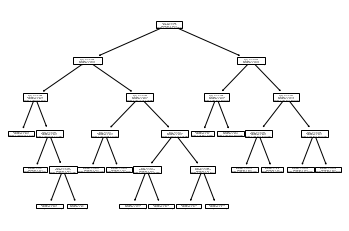

In [31]:
tree.plot_tree(decision_tree) 

In [32]:
#eveulate the result
y_pred_tree=decision_tree.predict(X_test)
print (confusion_matrix(y_test,y_pred_tree))
print(classification_report(y_test,y_pred_tree))
print("Time to Train {:.2f} s".format(time_took))

[[384  70]
 [ 36 449]]
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       454
           1       0.87      0.93      0.89       485

    accuracy                           0.89       939
   macro avg       0.89      0.89      0.89       939
weighted avg       0.89      0.89      0.89       939

Time to Train 0.01 s


 ## Gradient Boosting  

In [40]:
#find the best learning rate
lr_start = time.time()
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
best_rate=lr_list[0]
best_accuracy=0
for learning_rate in lr_list:
    gradientBoosting = GradientBoostingClassifier(n_estimators=15, learning_rate=learning_rate, max_features=4, max_depth=5, random_state=0)
    gradientBoosting.fit(X_train, y_train)
    if gradientBoosting.score(X_test, y_test)>best_accuracy:
        best_accuracy=gradientBoosting.score(X_test, y_test)
        best_rate=learning_rate
lr_end = time.time()
print(best_rate)

0.075


In [41]:
#Using the best learning rate to train the model
gradientBoosting = GradientBoostingClassifier(n_estimators=15, learning_rate=best_rate, max_features=4, max_depth=5, random_state=0)
start = time.time()
gradientBoosting.fit(X_train, y_train)
time_took = time.time()-start
#eveulate the result
y_pred_boosting = gradientBoosting.predict(X_test)
print (confusion_matrix(y_test,y_pred_boosting))
print(classification_report(y_test,y_pred_boosting))
print("Time to Find Best Learning Rate {:.2f} s".format(lr_end-lr_start))
print("Time to Train {:.2f} s".format(time_took))

[[399  55]
 [ 46 439]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       454
           1       0.89      0.91      0.90       485

    accuracy                           0.89       939
   macro avg       0.89      0.89      0.89       939
weighted avg       0.89      0.89      0.89       939

Time to Find Best Learning Rate 0.38 s
Time to Train 0.06 s


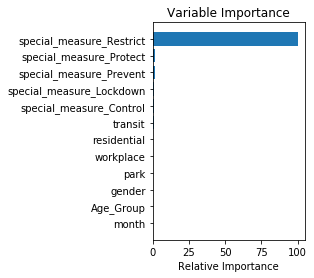

In [42]:
# Plot feature importance
feature_importance = gradientBoosting.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, column_list)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

 ## Random Forest

In [36]:
#training part
randomForest = RandomForestClassifier(n_estimators=10, criterion = 'entropy', max_depth=5, random_state=0,
                                      max_features='sqrt',min_impurity_decrease=1e-04,
                                      min_samples_leaf=1,min_samples_split=2)
start = time.time()
randomForest.fit(X_train,y_train)
time_took = time.time()-start
#show the decision condiction and the structure of the tree

#Estimators = classifier.estimators_
#for index, model in enumerate(Estimators):
    #each_condiction= export_text(model, feature_names=['Age_Group', 'Client_Gender', 'mobility', 'Special_Measures_Control', 'Special_Measures_Lockdown', 'Special_Measures_Protect', 'Special_Measures_Restrict'])
    #print(each_condiction)

In [37]:
#eveulate the result
y_pred_forest = randomForest.predict(X_test)
print (confusion_matrix(y_test,y_pred_forest))
print(classification_report(y_test,y_pred_forest))
print("Time to Train {:.2f} s".format(time_took))

[[396  58]
 [ 43 442]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       454
           1       0.88      0.91      0.90       485

    accuracy                           0.89       939
   macro avg       0.89      0.89      0.89       939
weighted avg       0.89      0.89      0.89       939

Time to Train 0.03 s


In [38]:
importances = randomForest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, column_list[indices[f]], importances[indices[f]]))

 1) Age_Group                      0.784520
 2) special_measure_Control        0.052139
 3) month                          0.041303
 4) transit                        0.025591
 5) workplace                      0.024810
 6) park                           0.024145
 7) residential                    0.019147
 8) gender                         0.010140
 9) special_measure_Restrict       0.007871
10) special_measure_Prevent        0.005257
11) special_measure_Lockdown       0.004356
12) special_measure_Protect        0.000721


 ## Part C
 

In [39]:
clf_svm = svm.SVC(kernel="linear", random_state=0, max_iter=3500).fit(X_train, y_train)  

#eveulate the result
y_pred_svm = clf_svm.predict(X_test)
print (confusion_matrix(y_test,y_pred_svm))
print(classification_report(y_test,y_pred_svm))

[[398  56]
 [ 45 440]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       454
           1       0.89      0.91      0.90       485

    accuracy                           0.89       939
   macro avg       0.89      0.89      0.89       939
weighted avg       0.89      0.89      0.89       939



In [56]:
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1).fit(data)

pred = clf.predict(data)
normal = data[pred == 1]
abnormal = data[pred == -1]
clf.score_samples(data)

array([124.37627194, 129.03535894, 129.51703902, ..., 132.5437969 ,
       130.90456688, 128.17283421])